In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

import torch
from torch import optim
from torch import nn

torch.manual_seed(1)

import time

# actual game
from helper import GameDriver

In [2]:
inputSize = 16; outputSize = 4; neuronCountJ = 200; neuronCountK = 100; neuronCountL = 50

model = nn.Sequential(nn.Linear(inputSize, neuronCountJ),
                       nn.ReLU(), 
                       nn.Linear(neuronCountJ, neuronCountK),
                       nn.ReLU(),
                       nn.Linear(neuronCountK, neuronCountL),
                       nn.ReLU(),
                       nn.Linear(neuronCountL, outputSize),
                       nn.Softmax(dim=1),
                     )

#model.load_state_dict(torch.load('C:\\Users\\mpaige\\Documents\\2048\\model.pt'))

In [3]:
opt = optim.SGD(model.parameters(), lr=0.1)

In [4]:
list(model.parameters())[0].sum()

tensor(-6.6785, grad_fn=<SumBackward0>)

In [5]:
loss = nn.SmoothL1Loss()
scores = []

In [11]:
end_time = time.time() + 60*30
print('Will end at:', time.ctime(end_time))

while time.time()<end_time:
    # run the games
    data = GameDriver()
    data.run_games(10, method=lambda layout:model(torch.tensor(np.log2(np.where(layout==0, 1, layout)), dtype=torch.float).reshape(1,-1)).detach().numpy().flatten())
    
    '''
    scores.append(data.final_scores.mean())
    weighted_scores = -1*data.final_scores+data.final_scores.max()#(data.final_scores-data.final_scores.min())/data.final_scores.std()
    weighted_scores = weighted_scores/weighted_scores.mean()
    '''
    
    game_penalties = np.array([data.layouts[i][-1].max() for i in range(len(data.layouts))])
    game_penalties = np.log2(game_penalties)
    scores.append(game_penalties.mean())
    game_penalties = (max(11, game_penalties.max())-game_penalties)/max(11, game_penalties.max())
    
    game_penalties = torch.tensor(np.concatenate([np.repeat(game_penalties[i], data.num_moves[i]) for i in range(len(data.num_moves))]), dtype=torch.float)[:, None]
    move_weights = torch.tensor(np.concatenate([np.array([1-np.exp(-3*x) for x in np.linspace(0, 1, num=data.num_moves[i])]) for i in range(len(data.num_moves))]), dtype=torch.float)[:, None]
    
    x = np.concatenate(data.layouts)
    x = torch.tensor(np.log2(np.where(x==0, 1, x)), dtype=torch.float)
    
    y_taken = torch.tensor(np.concatenate(data.moves), dtype=torch.float)
    
    '''
    # randomly sample moves to train on subset of all moves
    sample_indexes = list(RandomSampler(x, replacement=True, num_samples=1000))
    
    x = x[sample_indexes]
    game_penalties = game_penalties[sample_indexes]
    y_taken = y_taken[sample_indexes]
    '''
    
    # run model and update parameters
    y_hat = model(x)
    
    output = loss(move_weights*game_penalties*y_hat, move_weights*game_penalties*y_taken)
    output.backward()

    opt.step()
    opt.zero_grad()
    if len(scores)%50==0:
        print(list(model.parameters())[0].sum(), y_hat.std())

Will end at: Tue Oct 15 22:11:18 2019
tensor(-6.6809, grad_fn=<SumBackward0>) tensor(0.0237, grad_fn=<StdBackward0>)
tensor(-6.6783, grad_fn=<SumBackward0>) tensor(0.0231, grad_fn=<StdBackward0>)
tensor(-6.6755, grad_fn=<SumBackward0>) tensor(0.0228, grad_fn=<StdBackward0>)
tensor(-6.6723, grad_fn=<SumBackward0>) tensor(0.0224, grad_fn=<StdBackward0>)
tensor(-6.6686, grad_fn=<SumBackward0>) tensor(0.0235, grad_fn=<StdBackward0>)
tensor(-6.6646, grad_fn=<SumBackward0>) tensor(0.0207, grad_fn=<StdBackward0>)
tensor(-6.6606, grad_fn=<SumBackward0>) tensor(0.0219, grad_fn=<StdBackward0>)
tensor(-6.6560, grad_fn=<SumBackward0>) tensor(0.0211, grad_fn=<StdBackward0>)
tensor(-6.6513, grad_fn=<SumBackward0>) tensor(0.0209, grad_fn=<StdBackward0>)
tensor(-6.6460, grad_fn=<SumBackward0>) tensor(0.0214, grad_fn=<StdBackward0>)
tensor(-6.6407, grad_fn=<SumBackward0>) tensor(0.0193, grad_fn=<StdBackward0>)
tensor(-6.6348, grad_fn=<SumBackward0>) tensor(0.0219, grad_fn=<StdBackward0>)
tensor(-6.6292

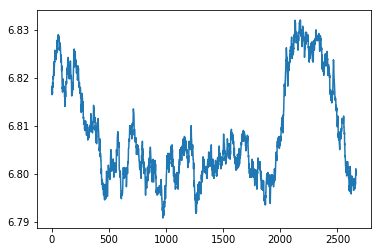

In [14]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.plot(moving_average(np.array(scores), 400))

In [13]:
np.corrcoef(scores, range(len(scores)))

array([[ 1.        , -0.01207315],
       [-0.01207315,  1.        ]])

In [10]:
#torch.save(model.state_dict(), 'C:\\Users\\mpaige\\Documents\\2048\\model2.pt')